In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [96]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sol = pd.read_csv('SampleSubmission.csv')

In [4]:
print(train.shape)
print(test.shape)

(4990, 13)
(3532, 12)


In [74]:
train.head()

,Item_ID,Store_ID,Item_Weight,Item_Sugar_Content,Item_Visibility,Item_Type,Item_Price,Store_Start_Year,Store_Size,Store_Location_Type,Store_Type,Item_Store_Returns,sqrt_Item_Price,cross_Item_weight,Cross_Item_visibility_weight
0,DRA12,BABATUNJI010,11.6,Low Sugar,0.068535,Soft Drinks,357.54,15.0,Medium,Cluster 3,Grocery Store,6.565378,18.908728,4147.464,284.246607
1,DRA12,BABATUNJI013,11.6,Low Sugar,0.040912,Soft Drinks,355.79,26.0,High,Cluster 3,Supermarket Type1,8.761345,18.862396,4127.164,168.849807
2,DRA12,BABATUNJI017,11.6,Low Sugar,0.041178,Soft Drinks,350.79,6.0,Medium,Cluster 2,Supermarket Type1,8.761345,18.729389,4069.164,167.558021
3,DRA12,BABATUNJI018,11.6,Low Sugar,0.041113,Soft Drinks,355.04,4.0,Medium,Cluster 3,Supermarket Type2,7.663046,18.842505,4118.464,169.321150
4,DRA12,BABATUNJI035,11.6,Ultra Low Sugar,0.000000,Soft Drinks,354.79,9.0,Small,Cluster 2,Supermarket Type1,7.817130,18.835870,4115.564,0.000000


In [75]:
test.head()

,Item_ID,Store_ID,Item_Weight,Item_Sugar_Content,Item_Visibility,Item_Type,Item_Price,Store_Start_Year,Store_Size,Store_Location_Type,Store_Type,sqrt_Item_Price,cross_Item_weight,Cross_Item_visibility_weight
0,DRA59,BABATUNJI010,8.270,Normal Sugar,0.214125,Soft Drinks,459.98,15.0,Medium,Cluster 3,Grocery Store,21.447144,3804.03460,814.539399
1,DRA59,BABATUNJI013,8.270,Normal Sugar,0.127821,Soft Drinks,464.98,26.0,High,Cluster 3,Supermarket Type1,21.563395,3845.38460,491.522720
2,DRB01,BABATUNJI013,7.390,Low Sugar,0.082171,Soft Drinks,477.38,26.0,High,Cluster 3,Supermarket Type1,21.849027,3527.83820,289.885806
3,DRB13,BABATUNJI010,6.115,Normal Sugar,0.011791,Soft Drinks,472.63,15.0,Medium,Cluster 3,Grocery Store,21.740055,2890.13245,34.076916
4,DRB13,BABATUNJI013,6.115,Normal Sugar,0.007038,Soft Drinks,473.13,26.0,High,Cluster 3,Supermarket Type1,21.751552,2893.18995,20.363654


In [7]:
sol.head()

,Item_Store_ID,Item_Store_Returns
0,DRA59_BABATUNJI010,100
1,DRA59_BABATUNJI013,100
2,DRB01_BABATUNJI013,100
3,DRB13_BABATUNJI010,100
4,DRB13_BABATUNJI013,100


In [8]:
sol.shape

(3532, 2)

In [10]:
submit = test[['Item_Store_ID']]

In [12]:
submit.shape

(3532, 1)

In [15]:
print(train['Item_Store_ID'].nunique())
print(test['Item_Store_ID'].nunique())

4990
3532


In [16]:
train.drop('Item_Store_ID', axis = 1, inplace = True)
test.drop('Item_Store_ID', axis = 1, inplace = True)

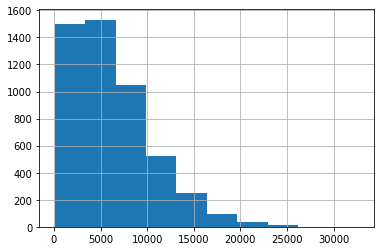

In [20]:
train['Item_Store_Returns'].hist()

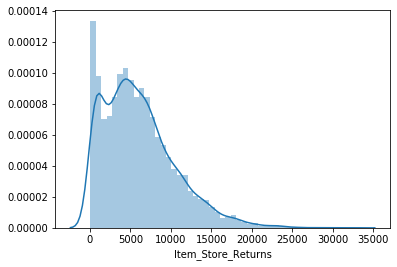

In [21]:
sns.distplot(train['Item_Store_Returns'])

In [30]:
train['Item_Store_Returns'] = np.log1p(train['Item_Store_Returns'])

In [29]:
# sns.distplot(np.exp(np.log1p(train['Item_Store_Returns'])))

In [73]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4990 entries, 0 to 4989
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Item_ID                       4990 non-null   object 
 1   Store_ID                      4990 non-null   object 
 2   Item_Weight                   4990 non-null   float64
 3   Item_Sugar_Content            4990 non-null   object 
 4   Item_Visibility               4990 non-null   float64
 5   Item_Type                     4990 non-null   object 
 6   Item_Price                    4990 non-null   float64
 7   Store_Start_Year              4990 non-null   float64
 8   Store_Size                    4990 non-null   object 
 9   Store_Location_Type           4990 non-null   object 
 10  Store_Type                    4990 non-null   object 
 11  Item_Store_Returns            4990 non-null   float64
 12  sqrt_Item_Price               4990 non-null   float64
 13  cro

In [33]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3532 entries, 0 to 3531
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Item_ID              3532 non-null   object 
 1   Store_ID             3532 non-null   object 
 2   Item_Weight          2871 non-null   float64
 3   Item_Sugar_Content   3532 non-null   object 
 4   Item_Visibility      3532 non-null   float64
 5   Item_Type            3532 non-null   object 
 6   Item_Price           3532 non-null   float64
 7   Store_Start_Year     3532 non-null   int64  
 8   Store_Size           2573 non-null   object 
 9   Store_Location_Type  3532 non-null   object 
 10  Store_Type           3532 non-null   object 
dtypes: float64(3), int64(1), object(7)
memory usage: 303.7+ KB


### Replacing Missing values

In [40]:
train['Item_Weight'].fillna(train['Item_Weight'].mean(), inplace = True)
test['Item_Weight'].fillna(test['Item_Weight'].mean(), inplace = True)

In [46]:
train['Store_Size'].value_counts()

Medium    1582
Small     1364
High       594
Name: Store_Size, dtype: int64

In [45]:
test['Store_Size'].value_counts()

Medium    1211
Small     1024
High       338
Name: Store_Size, dtype: int64

In [50]:
train['Store_Size'].fillna(train['Store_Size'].mode()[0], inplace = True)
test['Store_Size'].fillna(test['Store_Size'].mode()[0], inplace = True)

In [54]:
from datetime import datetime as dt

In [59]:
train['Store_Start_Year'] = dt.today().year - train['Store_Start_Year']
test['Store_Start_Year'] = dt.today().year - test['Store_Start_Year']

In [84]:
train['Store_Start_Year'] = train['Store_Start_Year'].astype('float')
test['Store_Start_Year'] = test['Store_Start_Year'].astype('float')

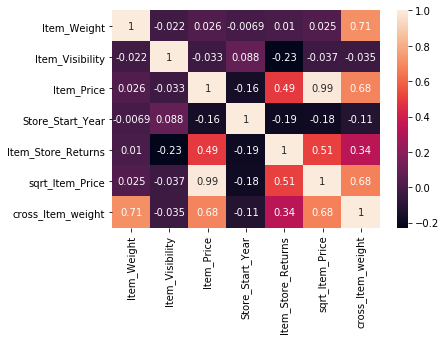

In [68]:
# sns.heatmap(train.corr(), annot = True)

In [67]:
train['sqrt_Item_Price'] = np.sqrt(train['Item_Price'])
test['sqrt_Item_Price'] = np.sqrt(test['Item_Price'])


train['cross_Item_weight'] = train['Item_Price'] * train['Item_Weight']
test['cross_Item_weight'] = test['Item_Price'] * test['Item_Weight']

train['Cross_Item_visibility_weight'] = train['Item_Price'] * train['Item_Weight'] * train['Item_Visibility']
test['Cross_Item_visibility_weight'] = test['Item_Price'] * test['Item_Weight'] * test['Item_Visibility']

In [85]:
data = train.drop('Item_Store_Returns', axis = 1)
target = train['Item_Store_Returns']

In [86]:
print(data.shape)
print(target.shape)

(4990, 14)
(4990,)


In [87]:
data['Item_ID'].nunique()

1451

In [88]:
data['Store_ID'].nunique()

10

In [89]:
cat_var = np.where(data.dtypes != np.float)[0]

In [90]:
cat_var

array([ 0,  1,  3,  5,  8,  9, 10], dtype=int64)

In [93]:
from sklearn. model_selection import train_test_split

In [94]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size= 0.2, random_state=42)

In [95]:
cat2 = CatBoostRegressor(iterations = 50, depth = 3, learning_rate = 0.1, loss_function = 'RMSE')
cat2.fit(X_train, y_train,cat_features = cat_var,eval_set = (X_test, y_test))

0:	learn: 0.9683601	test: 0.9302438	best: 0.9302438 (0)	total: 253ms	remaining: 12.4s
1:	learn: 0.9069113	test: 0.8740748	best: 0.8740748 (1)	total: 292ms	remaining: 7.02s
2:	learn: 0.8535017	test: 0.8256643	best: 0.8256643 (2)	total: 298ms	remaining: 4.67s
3:	learn: 0.8087234	test: 0.7845681	best: 0.7845681 (3)	total: 306ms	remaining: 3.51s
4:	learn: 0.7689635	test: 0.7488692	best: 0.7488692 (4)	total: 309ms	remaining: 2.78s
5:	learn: 0.7352322	test: 0.7181864	best: 0.7181864 (5)	total: 335ms	remaining: 2.45s
6:	learn: 0.7060298	test: 0.6914432	best: 0.6914432 (6)	total: 339ms	remaining: 2.08s
7:	learn: 0.6785201	test: 0.6673418	best: 0.6673418 (7)	total: 343ms	remaining: 1.8s
8:	learn: 0.6577959	test: 0.6482920	best: 0.6482920 (8)	total: 347ms	remaining: 1.58s
9:	learn: 0.6387794	test: 0.6322988	best: 0.6322988 (9)	total: 351ms	remaining: 1.4s
10:	learn: 0.6228595	test: 0.6188659	best: 0.6188659 (10)	total: 354ms	remaining: 1.26s
11:	learn: 0.6092506	test: 0.6070421	best: 0.6070421 (

In [97]:
pred22 = cat2.predict(X_test)
pred21 = cat2.predict(X_train)
print('TRAINING R2_Score: %.3f' % r2_score(y_train, pred21))
print('TRAINING RMSE: %.3f' % np.sqrt(mse(y_train, pred21)))
print('TESTING R2_Score: %.3f' % r2_score(y_test, pred22))
print('TESTING RMSE: %.3f' % np.sqrt(mse(y_test, pred22)))

TRAINING R2_Score: 0.750
TRAINING RMSE: 0.519
TESTING R2_Score: 0.712
TESTING RMSE: 0.533


In [98]:
cols = data.columns

In [99]:
feat_import = pd.Series(cat2.feature_importances_, index = data.columns)
feat_import

Item_ID                          0.000000
Store_ID                        29.667260
Item_Weight                      0.050069
Item_Sugar_Content               0.027175
Item_Visibility                  0.006530
Item_Type                        0.026166
Item_Price                       9.023068
Store_Start_Year                 1.207494
Store_Size                       0.014522
Store_Location_Type              0.661179
Store_Type                      49.845373
sqrt_Item_Price                  7.762914
cross_Item_weight                1.708250
Cross_Item_visibility_weight     0.000000
dtype: float64

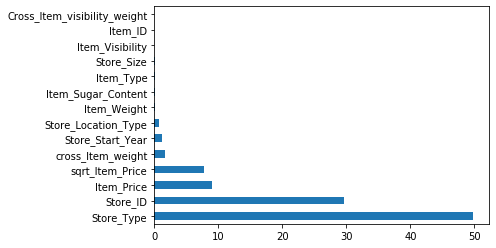

In [100]:
feat_import = pd.Series(cat2.feature_importances_, index = data.columns)
feat_import.sort_values(ascending = True).nlargest(20).plot(kind = 'barh')

In [101]:
data2 = data.drop(['Item_ID', 'Cross_Item_visibility_weight', 'Item_Visibility'], axis = 1)

In [103]:
cat_var2 = np.where(data2.dtypes != np.float)[0]

In [104]:
X_train, X_test, y_train, y_test = train_test_split(data2, target, test_size= 0.2, random_state=42)

In [105]:
cat3 = CatBoostRegressor(iterations = 50, depth = 3, learning_rate = 0.1, loss_function = 'RMSE')
cat3.fit(X_train, y_train, cat_features = cat_var2, eval_set = (X_test, y_test))

0:	learn: 0.9696228	test: 0.9289714	best: 0.9289714 (0)	total: 7.96ms	remaining: 390ms
1:	learn: 0.9085971	test: 0.8725840	best: 0.8725840 (1)	total: 14.7ms	remaining: 354ms
2:	learn: 0.8554448	test: 0.8246595	best: 0.8246595 (2)	total: 21.5ms	remaining: 337ms
3:	learn: 0.8106087	test: 0.7832024	best: 0.7832024 (3)	total: 24.8ms	remaining: 285ms
4:	learn: 0.7703947	test: 0.7466954	best: 0.7466954 (4)	total: 28.3ms	remaining: 255ms
5:	learn: 0.7361276	test: 0.7159519	best: 0.7159519 (5)	total: 31.9ms	remaining: 234ms
6:	learn: 0.7055817	test: 0.6881725	best: 0.6881725 (6)	total: 35.6ms	remaining: 219ms
7:	learn: 0.6787490	test: 0.6643694	best: 0.6643694 (7)	total: 39ms	remaining: 205ms
8:	learn: 0.6566192	test: 0.6443192	best: 0.6443192 (8)	total: 42.4ms	remaining: 193ms
9:	learn: 0.6360603	test: 0.6257656	best: 0.6257656 (9)	total: 45.8ms	remaining: 183ms
10:	learn: 0.6187496	test: 0.6103184	best: 0.6103184 (10)	total: 49.3ms	remaining: 175ms
11:	learn: 0.6059144	test: 0.5991551	best: 

In [106]:
pred32 = cat3.predict(X_test)
pred31 = cat3.predict(X_train)
print('TRAINING R2_Score: %.3f' % r2_score(y_train, pred31))
print('TRAINING RMSE: %.3f' % np.sqrt(mse(y_train, pred31)))
print('TESTING R2_Score: %.3f' % r2_score(y_test, pred32))
print('TESTING RMSE: %.3f' % np.sqrt(mse(y_test, pred32)))

TRAINING R2_Score: 0.750
TRAINING RMSE: 0.519
TESTING R2_Score: 0.715
TESTING RMSE: 0.531


In [110]:
test2 = test.drop(['Item_ID', 'Cross_Item_visibility_weight', 'Item_Visibility'], axis = 1)

In [111]:
print(data2.shape)
print(test2.shape)

(4990, 11)
(3532, 11)


In [113]:
cat3.fit(data2, target,cat_features = cat_var2, eval_set = (data2, target))

0:	learn: 0.9603708	test: 0.9602590	best: 0.9602590 (0)	total: 11.1ms	remaining: 544ms
1:	learn: 0.9005045	test: 0.9001374	best: 0.9001374 (1)	total: 19.5ms	remaining: 468ms
2:	learn: 0.8495557	test: 0.8490325	best: 0.8490325 (2)	total: 23.3ms	remaining: 365ms
3:	learn: 0.8039366	test: 0.8032890	best: 0.8032890 (3)	total: 32.7ms	remaining: 376ms
4:	learn: 0.7637925	test: 0.7630290	best: 0.7630290 (4)	total: 38ms	remaining: 342ms
5:	learn: 0.7295277	test: 0.7287394	best: 0.7287394 (5)	total: 42ms	remaining: 308ms
6:	learn: 0.6987569	test: 0.6979180	best: 0.6979180 (6)	total: 46ms	remaining: 282ms
7:	learn: 0.6731959	test: 0.6722703	best: 0.6722703 (7)	total: 50.1ms	remaining: 263ms
8:	learn: 0.6509796	test: 0.6499967	best: 0.6499967 (8)	total: 53.7ms	remaining: 245ms
9:	learn: 0.6314121	test: 0.6303962	best: 0.6303962 (9)	total: 57.6ms	remaining: 230ms
10:	learn: 0.6164261	test: 0.6153663	best: 0.6153663 (10)	total: 61.1ms	remaining: 217ms
11:	learn: 0.6028659	test: 0.6017759	best: 0.60

In [114]:
pred2 = cat3.predict(test2)

In [115]:
pred2.shape

(3532,)

In [116]:
sub2 = pd.DataFrame(pred2, columns = ['Item_Store_Returns'])

In [118]:
sub2.head()

,Item_Store_Returns
0,6.879814
1,8.803116
2,8.856973
3,6.889891
4,8.810511


In [120]:
sub2['Item_Store_Returns'] = round(np.exp(sub2['Item_Store_Returns'])).astype('int')

In [126]:
sub2.head()

,Item_Store_Returns
0,972
1,6655
2,7023
3,982
4,6704


In [127]:
submission = pd.concat([submit, sub2], axis = 1)

In [128]:
submission.head()

,Item_Store_ID,Item_Store_Returns
0,DRA59_BABATUNJI010,972
1,DRA59_BABATUNJI013,6655
2,DRB01_BABATUNJI013,7023
3,DRB13_BABATUNJI010,982
4,DRB13_BABATUNJI013,6704


In [129]:
submission.shape

(3532, 2)

In [130]:
submission.to_csv('My_submission.csv', index = False)